<a href="https://colab.research.google.com/github/Soumya120/ML-Projects/blob/main/DigitRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import (Dense,BatchNormalization,LeakyReLU,Reshape,Conv2DTranspose,Conv2D,Dropout,Flatten)
import matplotlib.pyplot as plt

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data() 


train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [ ]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

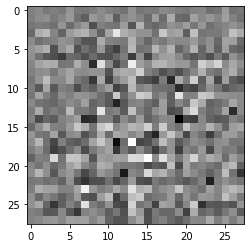

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
# Visualize the generated sample
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [ ]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00091643]], shape=(1, 1), dtype=float32)


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 100
num_examples_to_generate = 16
noise_dim = 100
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
@tf.function
def train_step(images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, 
                                               generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, 
                                                discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
import time
from IPython import display

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    for image_batch in dataset:
      train_step(image_batch)
    display.clear_output(wait=True)
    generate_and_save_images(generator,epoch + 1,seed)
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
  display.clear_output(wait=True)
  generate_and_save_images(generator,epochs,seed)


In [ ]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

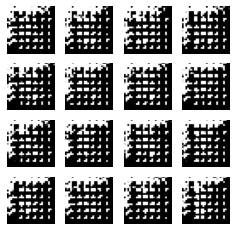

Time for epoch 81 is 166.2358808517456 sec


In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
import PIL 
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))
display_image(EPOCHS)

In [ ]:
import glob 
import imageio 
anim_file = 'abcd.gif'
with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  
display.Image(open('abcd.gif','rb').read())